In [5]:
!git clone https://github.com/siddharth-iyer1/dsl_final_project_ai_vs_real_art.git

Cloning into 'dsl_final_project_ai_vs_real_art'...
remote: Enumerating objects: 5220, done.
remote: Counting objects: 100% (95/95), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 5220 (delta 47), reused 64 (delta 20), pack-reused 5125
Receiving objects: 100% (5220/5220), 253.46 MiB | 24.40 MiB/s, done.
Resolving deltas: 100% (48/48), done.
Updating files: 100% (6833/6833), done.


In [3]:
import os
import numpy as np
from PIL import Image
import pywt
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.fft import fft2, fftshift
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.stats import skew, kurtosis
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

In [2]:
real_folder = '/content/dsl_final_project_ai_vs_real_art/detect ai artwork - resizing images for efficiency/ai vs real art/REAL'
fake_folder = '/content/dsl_final_project_ai_vs_real_art/detect ai artwork - resizing images for efficiency/ai vs real art/FAKE'

output_real_folder = '/content/frequency_analysis/real_Haar'
output_fake_folder = '/content/frequency_analysis/fake_Haar'
os.makedirs(output_real_folder, exist_ok=True)
os.makedirs(output_fake_folder, exist_ok=True)

def haar_transform(image_np):
    # Perform 2D Haar transform
    coeffs = pywt.dwt2(image_np, 'haar')
    cA, (cH, cV, cD) = coeffs
    return cA

def save_haar_transform(image_path, output_path):
    image = Image.open(image_path).convert('L')
    image_np = np.array(image)
    cA = haar_transform(image_np)
    np.save(output_path, cA)


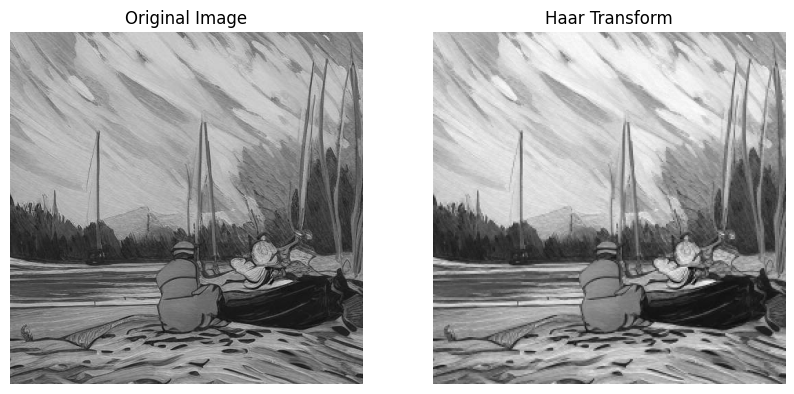

In [6]:
# Process real images
for filename in os.listdir(real_folder):
    image_path = os.path.join(real_folder, filename)
    output_path = os.path.join(output_real_folder, filename.split('.')[0] + '_1.npy')
    save_haar_transform(image_path, output_path)

# Process fake images
for filename in os.listdir(fake_folder):
    image_path = os.path.join(fake_folder, filename)
    output_path = os.path.join(output_fake_folder, filename.split('.')[0] + '_0.npy')
    save_haar_transform(image_path, output_path)

# Plot example
sample_image_path = os.path.join(real_folder, os.listdir(real_folder)[0])
sample_image = Image.open(image_path).convert('L')
sample_image_np = np.array(sample_image)

# Perform Haar transform
haar_coeff = haar_transform(sample_image_np)

# Plot both original and Haar transformed images side by side
plt.figure(figsize=(10, 5))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Haar transformed image
plt.subplot(1, 2, 2)
plt.imshow(haar_coeff, cmap='gray')
plt.title('Haar Transform')
plt.axis('off')

plt.show()

In [7]:
def get_mean_freq_2d(magnitude_spectrum):
    return np.mean(magnitude_spectrum)

def get_std_freq_2d(magnitude_spectrum):
    return np.std(magnitude_spectrum)

def get_skewness_freq_2d(magnitude_spectrum):
    return skew(magnitude_spectrum.flatten())

def get_kurtosis_freq_2d(magnitude_spectrum):
    return kurtosis(magnitude_spectrum.flatten())

def get_energy_freq_2d(magnitude_spectrum):
    return np.sum(magnitude_spectrum**2)

def get_entropy_freq_2d(magnitude_spectrum):
    normalized_spectrum = magnitude_spectrum / np.sum(magnitude_spectrum)
    return -np.sum(normalized_spectrum * np.log(normalized_spectrum + 1e-8))

In [8]:
def extract_features_and_create_dataframe2(real_folder, fake_folder):
    data = []
    columns = ['Mean', 'Std', 'Skewness', 'Kurtosis', 'Energy', 'Entropy', 'Label']

    def process_folder(folder, label):
        for filename in os.listdir(folder):
            file_path = os.path.join(folder, filename)
            magnitude_spectrum = np.load(file_path)

            mean = get_mean_freq_2d(magnitude_spectrum)
            std = get_std_freq_2d(magnitude_spectrum)
            skewness = get_skewness_freq_2d(magnitude_spectrum)
            kurtosis = get_kurtosis_freq_2d(magnitude_spectrum)
            energy = get_energy_freq_2d(magnitude_spectrum)
            entropy = get_entropy_freq_2d(magnitude_spectrum)

            data.append([mean, std, skewness, kurtosis, energy, entropy, label])


    process_folder(real_folder, 1)  # Real images labeled as 1
    process_folder(fake_folder, 0)  # Fake images labeled as 0

    # Create DataFrame
    df = pd.DataFrame(data, columns=columns)
    return df

In [9]:
real_folder2 = '/content/frequency_analysis/real_Haar'
fake_folder2 = '/content/frequency_analysis/fake_Haar'

feature_df = extract_features_and_create_dataframe2(real_folder2, fake_folder2)

feature_df.to_csv('image_fft_featuresHaar.csv', index=False)
print(feature_df.head())

         Mean         Std  Skewness  Kurtosis        Energy    Entropy  Label
0  237.992928   94.774877 -0.652194 -0.298828  4.300663e+09  10.992223      1
1  195.806129  113.494070 -0.183660 -1.770144  3.356816e+09  10.898694      1
2  133.141907   64.255502  0.993122  0.916806  1.432324e+09  10.979488      1
3  292.293030   98.658611 -0.851673  0.170929  6.236978e+09  11.020047      1
4  316.481102   92.649404 -1.148307  0.754138  7.126660e+09  11.037502      1


In [10]:
df = pd.read_csv('image_fft_featuresHaar.csv')

X = df.drop('Label', axis=1)
y = df['Label']

X_trainHaar, X_testHaar, y_trainHaar, y_testHaar = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
xgb_modelHaar = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False, seed=42)
xgb_modelHaar.fit(X_trainHaar, y_trainHaar)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [12]:
y_pred = xgb_modelHaar.predict(X_testHaar)
accuracy = accuracy_score(y_testHaar, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_testHaar, y_pred))

Accuracy: 0.873900293255132
              precision    recall  f1-score   support

           0       0.86      0.88      0.87       328
           1       0.89      0.86      0.88       354

    accuracy                           0.87       682
   macro avg       0.87      0.87      0.87       682
weighted avg       0.87      0.87      0.87       682



In [ ]:
# GridSearch Tuning

parameters = {
    'max_depth': [7, 8, 10],             # Maximum depth of a tree
    'learning_rate': [0.01, 0.05, 0.1],  # Boosting learning rate
    'n_estimators': [300, 400],       # Number of gradient boosted trees
    'gamma': [0, 0.1, 0.2],          # Minimum loss reduction required to make further partition
    'reg_alpha': [0.1, 0.5, 1.0],                 # L1 regularization term on weights
    'reg_lambda': [0.5, 0.1, 0.01],               # L2 regularization term on weights
}

grid_searchHaar = GridSearchCV(xgb.XGBClassifier(eval_metric='logloss'), parameters, cv=10, scoring='accuracy')
grid_searchHaar.fit(X_trainHaar, y_trainHaar)


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'gamma': [0, 0.1, 0.2],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [7, 8, 10], 'n_estimators': [300, 400],
                         'reg_alpha': [0.1, 0.5, 1.0],
                         'reg_lambda': [0.5, 0.1, 0.01]},
             scoring='accuracy')

In [ ]:

print(f"Best parameters: {grid_searchHaar.best_params_}")
print(f"Best score: {grid_searchHaar.best_score_}")

Best parameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 300, 'reg_alpha': 1.0, 'reg_lambda': 0.01}
Best score: 0.8625444408532644


In [ ]:
best_modelHaar = grid_searchHaar.best_estimator_
y_pred = best_modelHaar.predict(X_testHaar)
accuracy = accuracy_score(y_testHaar, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_testHaar, y_pred))

Accuracy: 0.8768328445747801
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       328
           1       0.90      0.86      0.88       354

    accuracy                           0.88       682
   macro avg       0.88      0.88      0.88       682
weighted avg       0.88      0.88      0.88       682

